<a href="https://colab.research.google.com/github/Gus-oss/MachineLearning/blob/main/MachineLearningTarea6_AprendizajeAutomatico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning: Análisis y técnicas de machine learning de los datos sobre influenza, COVID-19 y otros virus respiratorios.

## Paquetes por instalar

In [ ]:
!pip install pandas scikit-learn gower

In [ ]:
! pip install tensorflow

In [ ]:
!pip install imbalanced-learn

## Librerias y creación de carpeta de imagenes.

In [ ]:
#Descargar la base de datos de drive
from google.colab import drive
from google.colab import files #descargar archivos

#Importamos las librerias que utilizaremos a lo largo del documento
import pandas as pd
import numpy as np
import statistics as stats   #utilizado en la parte estadistica descriptiva
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import os #Se utilizo para guardar las imagenes (carpeta) y para guardar las imagenes en la carpeta
import plotly.graph_objects as go #esta libreria es para hacer graficos dinamicos
from statsmodels.graphics.gofplots import qqplot #se utilizo para hacer la grafica cuartil cuartil

# Librerias para Machine Learning
from sklearn.feature_selection import f_regression #para la seleccion de caracteristicas
from sklearn.preprocessing import MinMaxScaler #para tener todas las variables entre 0 y 1
from sklearn.feature_selection import VarianceThreshold #para la prueba de varianza
from sklearn.feature_selection import mutual_info_regression #para la prueba de seleccion mutua
from sklearn.linear_model import LinearRegression #regresion lineal simple
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS #Hace toda la combinatoria
#de las variables que tenemos en un conjunto de datos
from mlxtend.feature_selection import SequentialFeatureSelector as SFS #para la parte de sequential selector
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN #para agrupación
import gower #para dbscan con la metrica de gower
from sklearn.neighbors import NearestNeighbors# para la grafica del codo
from sklearn.metrics import silhouette_score #grafica del codo
from sklearn.manifold import TSNE #vizualizacion de cluster
from sklearn.decomposition import PCA #vizualizacion de cluster
from sklearn.preprocessing import MinMaxScaler #normalizacion de los datos
from sklearn.preprocessing import OneHotEncoder

#TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.impute import SimpleImputer #imputar
import joblib #guardar mapeos
from sklearn.impute import SimpleImputer #imputar valores NaN
import tensorflow as tf #para el algoritmo (1-2)
from tensorflow.keras.utils import to_categorical #(2-2)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report #matriz de confusion para red neuronal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Carpeta única para guardar las imágenes
IMAGES_PATH = "Galeria"  # Nombre de la carpeta (puedes cambiarlo)
os.makedirs(IMAGES_PATH, exist_ok=True) # Crea la carpeta si no existe

def save_fig(fig_id, tight_layout=True, fig_extension="pdf", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Imagen guardada como ", fig_id, "en la carpeta", IMAGES_PATH) #Mensaje mas informativo
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#Recomendación del Dr. Alberto Benavidez es generar imagenes en PDF para la creacion de articulos.
#A demas de antes de llamar la función, escribir plt.tight_layout() para quitar espacios
#inecesarios en las imagenes, este plt.tight_layout() ya se encuentra en la funcion pra guardar imagenes

In [ ]:
drive.mount('/content/drive') #coneccion con drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Obtencion de datos.

Los datos se actualizan cada cierto periodo de tiempo. Para esto, se automatizo la optención de los datos para que al momento de ejecutar el programa se estudien los datos mas recientes posibles publicados por la Direccion de Epidemiología de México.

In [ ]:
df_covid = pd.read_csv('/content/drive/MyDrive/Covid19_26-10-2025/COVID19MEXICO.csv')
#correr esta celda cuando el codigo de extraccion de datos automatico no funcione (que raro que siempre me pase en viernes)

In [ ]:
import requests
from bs4 import BeautifulSoup

# URL de la página de datos abiertos
url = 'https://www.gob.mx/salud/documentos/datos-abiertos-152127'

# Obtener el HTML de la página
response = requests.get(url)
response.raise_for_status()
soup = BeautifulSoup(response.content, 'html.parser')

# Imprimir todos los enlaces en la página para ver su estructura
print("Enlaces encontrados en la página:")
for a in soup.find_all('a', href=True):
    print(a['href'])

Enlaces encontrados en la página:
/
/tramites
/gobierno
/salud/en
https://www.gob.mx/busqueda?utf8=✓
?tab=
/salud/es/archivo/prensa
/salud/es/#390
/salud/es/archivo/documentos
/salud/es/archivo/acciones_y_programas
/salud/es/archivo/multimedia
http://portal.salud.gob.mx/sites/transparencia/transparencia/proteccion_datos/proteccion_1_1.html
http://portal.salud.gob.mx/sites/transparencia/transparencia/transparencia/transparencia_1.html
http://www.gob.mx
/salud
/salud/articulos/mexico-cumple-35-anos-libre-de-poliomielitis-gracias-a-una-labor-coordinada-destacan-autoridades-expertos-y-organismos-internacionales
/salud/articulos/vacunacion-pieza-clave-en-la-erradicacion-de-la-poliomielitis-en-mexico
/salud/articulos/lavado-de-manos-esencial-en-la-prevencion-de-infecciones
/salud/articulos/hospital-general-de-mexico-realiza-jornada-de-reconstruccion-mamaria-en-beneficio-de-mujeres-sobrevivientes-de-cancer
/salud/articulos/secretaria-de-salud-reconoce-en-su-dia-a-sus-trabajadoras-y-trabajador

In [ ]:
import requests
import zipfile
import io

# URL del Diccionario de datos
diccionario_url = 'https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_influenza_covid19.zip'

# Descargar y abrir el archivo ZIP del Diccionario de datos
diccionario_zip_response = requests.get(diccionario_url)
diccionario_zip_response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(diccionario_zip_response.content)) as diccionario_zip:
    # Listar los nombres de los archivos en el ZIP
    print("Archivos contenidos en el ZIP del Diccionario de datos:")
    for file_name in diccionario_zip.namelist():
        print(file_name)

Archivos contenidos en el ZIP del Diccionario de datos:
COVID19MEXICO.csv


In [ ]:
import requests
import zipfile
import io
import pandas as pd

# URLs directas para los archivos ZIP
covid_data_url = 'https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_influenza_covid19.zip'
diccionario_url = 'https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/diccionario_datos_abiertos.zip'

def descargar_datos_covid():
    # Descargar y procesar el archivo ZIP de datos COVID-19
    print("Descargando archivo ZIP de datos COVID-19 desde:", covid_data_url)
    covid_zip_response = requests.get(covid_data_url)
    covid_zip_response.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(covid_zip_response.content)) as covid_zip:
        for file_name in covid_zip.namelist():
            if file_name.endswith('.csv'):
                print(f"Extrayendo {file_name}...")
                with covid_zip.open(file_name) as csv_file:
                    df_covid = pd.read_csv(csv_file)
                    print("Datos COVID-19 cargados correctamente en el DataFrame.")
                    break  # Salir después de encontrar el archivo CSV

    # Descargar y procesar el archivo ZIP del Diccionario de datos
    print("Descargando archivo ZIP del Diccionario de datos desde:", diccionario_url)
    diccionario_zip_response = requests.get(diccionario_url)
    diccionario_zip_response.raise_for_status()

    with zipfile.ZipFile(io.BytesIO(diccionario_zip_response.content)) as diccionario_zip:
        # Cargar los archivos Excel
        excel_file_catalogos = pd.read_excel(diccionario_zip.open('240708 Catalogos.xlsx'))
        df_descriptores = pd.read_excel(diccionario_zip.open('240708 Descriptores_.xlsx'))
        print("Archivos del Diccionario de datos cargados correctamente en DataFrames.")

        # Cargar hojas específicas en DataFrames separados
        df_enti = pd.read_excel(diccionario_zip.open('240708 Catalogos.xlsx'), sheet_name='Catálogo de ENTIDADES')
        df_muni = pd.read_excel(diccionario_zip.open('240708 Catalogos.xlsx'), sheet_name='Catálogo MUNICIPIOS')
        df_sector = pd.read_excel(diccionario_zip.open('240708 Catalogos.xlsx'), sheet_name='Catálogo SECTOR')
        df_pcr = pd.read_excel(diccionario_zip.open('240708 Catalogos.xlsx'), sheet_name='Catálogo RESULTADO_PCR')

    return df_covid, excel_file_catalogos, df_descriptores, df_enti, df_muni, df_sector, df_pcr

# Ejecutar la función y cargar los datos en los DataFrames
df_covid, excel_file_catalogos, df_descriptores, df_enti, df_muni, df_sector, df_pcr = descargar_datos_covid()

Descargando archivo ZIP de datos COVID-19 desde: https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_influenza_covid19.zip
Extrayendo COVID19MEXICO.csv...
Datos COVID-19 cargados correctamente en el DataFrame.
Descargando archivo ZIP del Diccionario de datos desde: https://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/diccionario_datos_abiertos.zip
Archivos del Diccionario de datos cargados correctamente en DataFrames.


## Limpieza de la base de datos.

En este apartado nos encargaremos de checar valores nulos, formato de fechas, filas duplicadas y verificaremos errores al momento de capturar datos.

### Vizualisación de la base de datos

In [ ]:
df_covid #visualizamos la base de datos

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,RESULTADO_PCR,RESULTADO_PCR_COINFECCION,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL_COVID,CLASIFICACION_FINAL_FLU,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2025-10-28,167f1a,1,12,1,2,1,1,3,1,...,997,997,2,97,6,6,99,México,97,97
1,2025-10-28,gbbb80b,1,4,20,2,20,20,413,1,...,997,997,2,97,6,6,99,México,97,97
2,2025-10-28,gd8311d,1,8,9,1,9,9,12,1,...,997,997,2,97,6,6,99,México,97,97
3,2025-10-28,g98e198,1,15,21,1,21,21,114,2,...,3,998,2,97,7,3,99,México,97,2
4,2025-10-28,g5075fe,1,6,9,1,29,9,5,2,...,5,5,2,97,7,7,99,México,97,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129172,2025-10-28,g7b5944,1,12,4,2,28,4,2,2,...,999,999,2,97,6,6,99,México,97,2
129173,2025-10-28,g4a3482,1,15,17,1,17,17,7,1,...,997,997,2,97,6,6,99,México,97,97
129174,2025-10-28,gdeb4f5,1,12,4,2,4,4,2,2,...,999,999,2,97,6,6,99,México,97,1
129175,2025-10-28,g5e54db,1,6,29,2,29,29,18,2,...,999,999,2,97,6,6,99,México,97,1


### Valores nulos

In [ ]:
# Revisión de valores faltantes (NaN)
# Verificamos cuántos valores faltantes hay por columna
valores_nulos = df_covid.isnull().sum()
print("Valores faltantes por columna:\n", valores_nulos)

Valores faltantes por columna:
 FECHA_ACTUALIZACION          0
ID_REGISTRO                  0
ORIGEN                       0
SECTOR                       0
ENTIDAD_UM                   0
SEXO                         0
ENTIDAD_NAC                  0
ENTIDAD_RES                  0
MUNICIPIO_RES                0
TIPO_PACIENTE                0
FECHA_INGRESO                0
FECHA_SINTOMAS               0
FECHA_DEF                    0
INTUBADO                     0
NEUMONIA                     0
EDAD                         0
NACIONALIDAD                 0
EMBARAZO                     0
HABLA_LENGUA_INDIG           0
INDIGENA                     0
DIABETES                     0
EPOC                         0
ASMA                         0
INMUSUPR                     0
HIPERTENSION                 0
OTRA_COM                     0
CARDIOVASCULAR               0
OBESIDAD                     0
RENAL_CRONICA                0
TABAQUISMO                   0
OTRO_CASO                    0
TOMA_MU

Podemos encontrar que en el conjunto de datos no hay datos faltantes.

### Fortmato Fechas

In [ ]:
# Revisión de tipos de datos
# Convertimos las columnas de fecha a formato datetime para análisis temporal
df_covid['FECHA_INGRESO']  = pd.to_datetime(
    df_covid['FECHA_INGRESO'],
    format="%Y-%m-%d",
    errors="coerce"
)

df_covid['FECHA_SINTOMAS'] = pd.to_datetime(
    df_covid['FECHA_SINTOMAS'],
    format="%Y-%m-%d",
    errors="coerce"
)

df_covid['FECHA_DEF']      = pd.to_datetime(
    df_covid['FECHA_DEF'],
    format="%Y-%m-%d",
    errors="coerce"
)

In [ ]:
df_covid["FECHA_INGRESO"].unique() #NO CUENTA CON VALORES NaT

<DatetimeArray>
['2025-04-21 00:00:00', '2025-01-02 00:00:00', '2025-01-01 00:00:00',
 '2025-10-10 00:00:00', '2025-06-15 00:00:00', '2025-08-28 00:00:00',
 '2025-01-24 00:00:00', '2025-05-01 00:00:00', '2025-03-12 00:00:00',
 '2025-02-05 00:00:00',
 ...
 '2025-10-18 00:00:00', '2025-10-19 00:00:00', '2025-10-20 00:00:00',
 '2025-10-21 00:00:00', '2025-10-22 00:00:00', '2025-10-23 00:00:00',
 '2025-10-24 00:00:00', '2025-10-25 00:00:00', '2025-10-26 00:00:00',
 '2025-10-27 00:00:00']
Length: 300, dtype: datetime64[ns]

In [ ]:
df_covid["FECHA_SINTOMAS"].unique() #No cuenta con valores NaT

<DatetimeArray>
['2025-04-20 00:00:00', '2025-01-01 00:00:00', '2025-01-02 00:00:00',
 '2025-10-10 00:00:00', '2025-06-12 00:00:00', '2025-08-28 00:00:00',
 '2025-01-24 00:00:00', '2025-04-30 00:00:00', '2025-03-12 00:00:00',
 '2025-02-04 00:00:00',
 ...
 '2025-10-18 00:00:00', '2025-10-19 00:00:00', '2025-10-20 00:00:00',
 '2025-10-21 00:00:00', '2025-10-22 00:00:00', '2025-10-23 00:00:00',
 '2025-10-24 00:00:00', '2025-10-25 00:00:00', '2025-10-26 00:00:00',
 '2025-10-27 00:00:00']
Length: 300, dtype: datetime64[ns]

In [ ]:
df_covid["FECHA_DEF"].unique()

<DatetimeArray>
[                'NaT', '2025-01-31 00:00:00', '2025-01-10 00:00:00',
 '2025-01-03 00:00:00', '2025-01-16 00:00:00', '2025-02-02 00:00:00',
 '2025-01-02 00:00:00', '2025-01-04 00:00:00', '2025-01-06 00:00:00',
 '2025-01-22 00:00:00',
 ...
 '2025-10-14 00:00:00', '2025-10-18 00:00:00', '2025-10-13 00:00:00',
 '2025-10-23 00:00:00', '2025-10-17 00:00:00', '2025-10-25 00:00:00',
 '2025-10-21 00:00:00', '2025-10-22 00:00:00', '2025-10-26 00:00:00',
 '2025-10-27 00:00:00']
Length: 300, dtype: datetime64[ns]

Al cambiar las fechas a datatime con el formato yyyy-mm-dd apreciamos que en la columna *FECHA_DEF* se encuentran valores NaT( conjunto original de datos se tenia como 9999-99-99, pero al hacer la conversion a datatime se colodaron NaT)  los cuales significan Not a Time, lo que quiere decir que no se tiene registro de fecha de defunción. Esto puede significar :


*   el paciente fallecio y no se registro la fecha de defunción
*   o el paciente no fallecio y se recupero

Se investiga cuantos NaT se tienen registrados en el conjunto de datos.

In [ ]:
# Contar los valores NaT en una columna específica
nat_count_fecha_def = df_covid['FECHA_DEF'].isna().sum()
print(f"Valores NaT en la columna FECHA_DEF: {nat_count_fecha_def}")

Valores NaT en la columna FECHA_DEF: 124326


In [ ]:
# Obtener el número de filas
num_filas = df_covid.shape[0]
print(f"El DataFrame tiene {num_filas} filas.")

El DataFrame tiene 129177 filas.


Como el numero de NaT que hay en la columna FECHA_DEF es muy cercano al numero de filas que tiene el dataframe df_covid se opto por no eliminar las filas que tengan NaT y se conservaran.

### Duplicados

In [ ]:
num_filas_original = df_covid.shape[0]
num_filas_unicas = df_covid.drop_duplicates().shape[0]
print(f"Total filas originales: {num_filas_original}")
print(f"Total filas únicas: {num_filas_unicas}")
#En caso de encontrar filas duplicadas se tendria que utilizar df_covid = df_covid.drop_duplicates()

Total filas originales: 129177
Total filas únicas: 129177


No se encontraron filas duplicadas en el conjunto de datos.

**texto en negrita**### Edad

In [ ]:
df_covid['EDAD'].unique()

array([  8,  26,  57,   2,  86,  23,  75,  18,  24,  47,  65,  51,  69,
        62,  10,  67,  30,  64,  29,  32,  40,   1,  19,   6,  63,  39,
        48, 102,  54,  31,  25,  70,  33,  71,  37,  44,  28,  87,  49,
         3,  14,  56,  77,  27,  68,   4,  42,  72,  82,  17,  52,  73,
        22,   9,  88,  16,  53,  46,  55,  76,  34,  59,  61,  36,  21,
        79,  38,  41,  74,  85,  58,  60,  83,  80,  35,  45,  43,  89,
        94,  84,  66,  12,  50,  96,   5,   7,  11,  13,  90,   0,  20,
        81,  95,  78,  15,  92,  91,  93,  98,  97,  99, 101, 103, 110,
       100, 105, 104, 106, 107, 108, 111, 121])

Verificamos que las edades estan correctas y que no hay errores de typing al momento de realizar la captura de las edades.

## Estadistica Descriptiva.

En esta sección realizaremos:

- Comprobar si en el conjunto de datos son parametricos o no parametricos.
- Calcular estadisticos descriptivos básicos.
- Matriz de correlaciones.
- Realizar pruebas de hipótesis a partir de las conclusiones obtenidas en la matriz de correlación.
- Realizar graficos estadisticos.

### Estadisticos.

Realizamos un analisis de los estadisticos de media, moda y mediana a la variable EDAD del conjunto de datos.

In [ ]:
edades = df_covid['EDAD'].tolist()

print("Promedio:", stats.mean(edades))
print("Mediana :", stats.median(edades))
print("Moda(s) :", stats.multimode(edades))

Promedio: 36.22663477244401
Mediana : 34
Moda(s) : [1]


La mayoría de los casos de COVID-19 en este conjunto de datos corresponden a adultos jóvenes (aproximadamente 37 años, mediana 35 años). Sin embargo, la moda de 1 año sugiere un pico artificial o un sesgo: podría reflejar una alta proporción de casos en menores de 1 año.

Ahora realizamos un diagrama de cajas con vigotes para esta misma variable

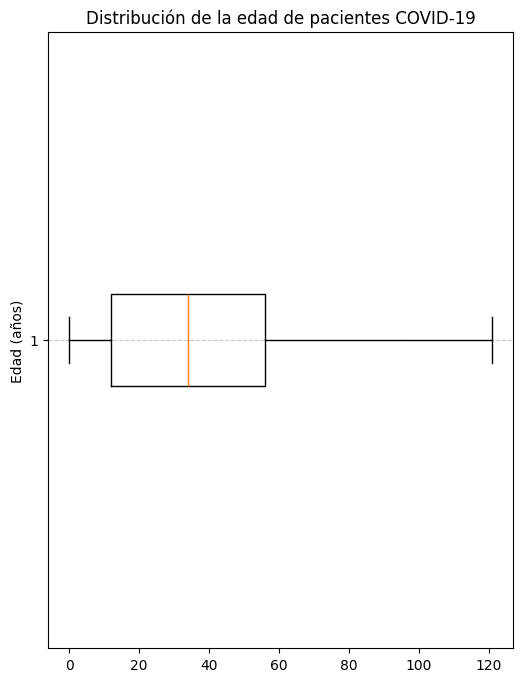

Imagen guardada como  boxplot_edad en la carpeta Galeria


<Figure size 640x480 with 0 Axes>

In [ ]:
# Elimina valores nulos si existen
edades = df_covid['EDAD']

plt.figure(figsize=(6, 8))
plt.boxplot(edades, vert=False)
plt.title('Distribución de la edad de pacientes COVID-19')
plt.ylabel('Edad (años)')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # líneas de referencia
plt.show()


save_fig("boxplot_edad", fig_extension="pdf")

Imagen guardada como  violinplot_edad en la carpeta Galeria


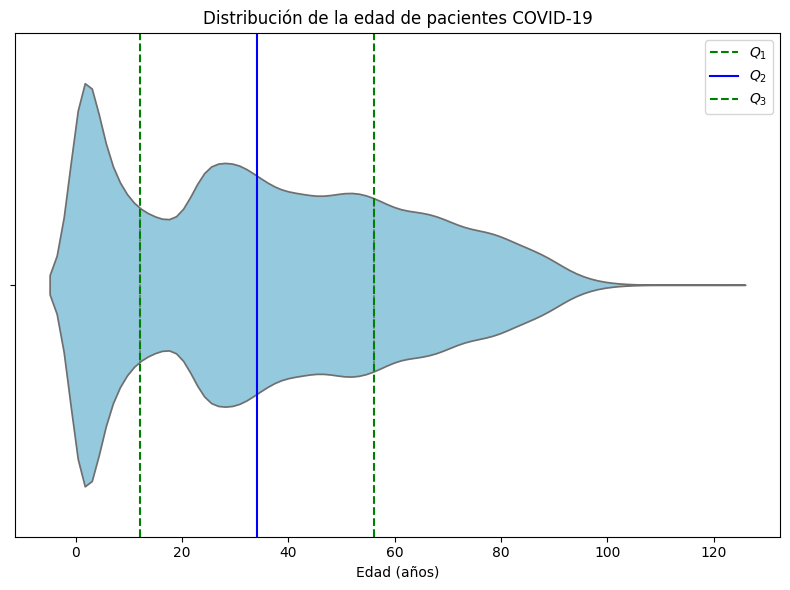

In [ ]:
plt.figure(figsize=(8,6))
sns.violinplot(x=df_covid['EDAD'], color="skyblue", inner="quartile")
plt.axvline(
    x = stats.quantiles(df_covid['EDAD'], n=4)[0],
    label = '$Q_1$',
    linestyle = '--',
    color = 'green'
)
plt.axvline(
    x = stats.quantiles(df_covid['EDAD'], n=4)[1],
    label = '$Q_2$',
    linestyle = '-',
    color = 'blue'
)
plt.axvline(
    x = stats.quantiles(df_covid['EDAD'], n=4)[2],
    label = '$Q_3$',
    linestyle = '--',
    color = 'green'
)
plt.legend()
plt.title("Distribución de la edad de pacientes COVID-19")
plt.xlabel("Edad (años)")

# Guardar la figura
save_fig("violinplot_edad", fig_extension="pdf")

plt.show()

Grafica Cuartil-cuartil de las edades del conjunto de datos del covid-19

Imagen guardada como  cuartilcuartil_edad en la carpeta Galeria


<Figure size 640x480 with 0 Axes>

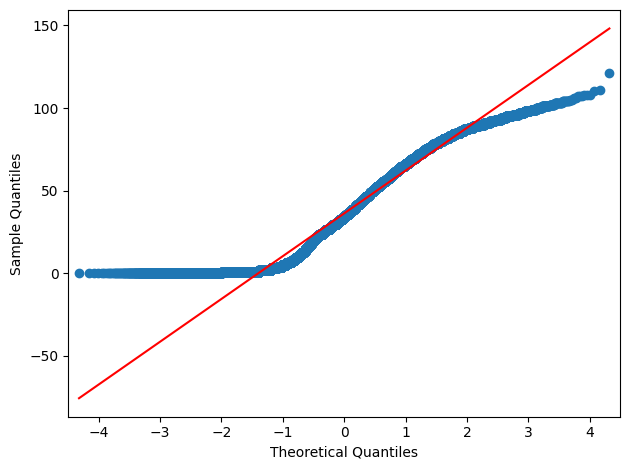

In [ ]:
plt.figure()
qqplot(df_covid['EDAD'], line ='s')

# Guardar la figura
save_fig("cuartilcuartil_edad", fig_extension="pdf")
plt.show()

De acuerdo a la grafica, se sospecha que la muestra respecto a las edades no es parametrica.

### Correlaciones

In [ ]:
df_covid.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_PCR',
       'RESULTADO_PCR_COINFECCION', 'TOMA_MUESTRA_ANTIGENO',
       'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL_COVID',
       'CLASIFICACION_FINAL_FLU', 'MIGRANTE', 'PAIS_NACIONALIDAD',
       'PAIS_ORIGEN', 'UCI'],
      dtype='object')

Imagen guardada como  Correlacion_Condiciones_Pacientes_Intubados_COVID19 en la carpeta Galeria


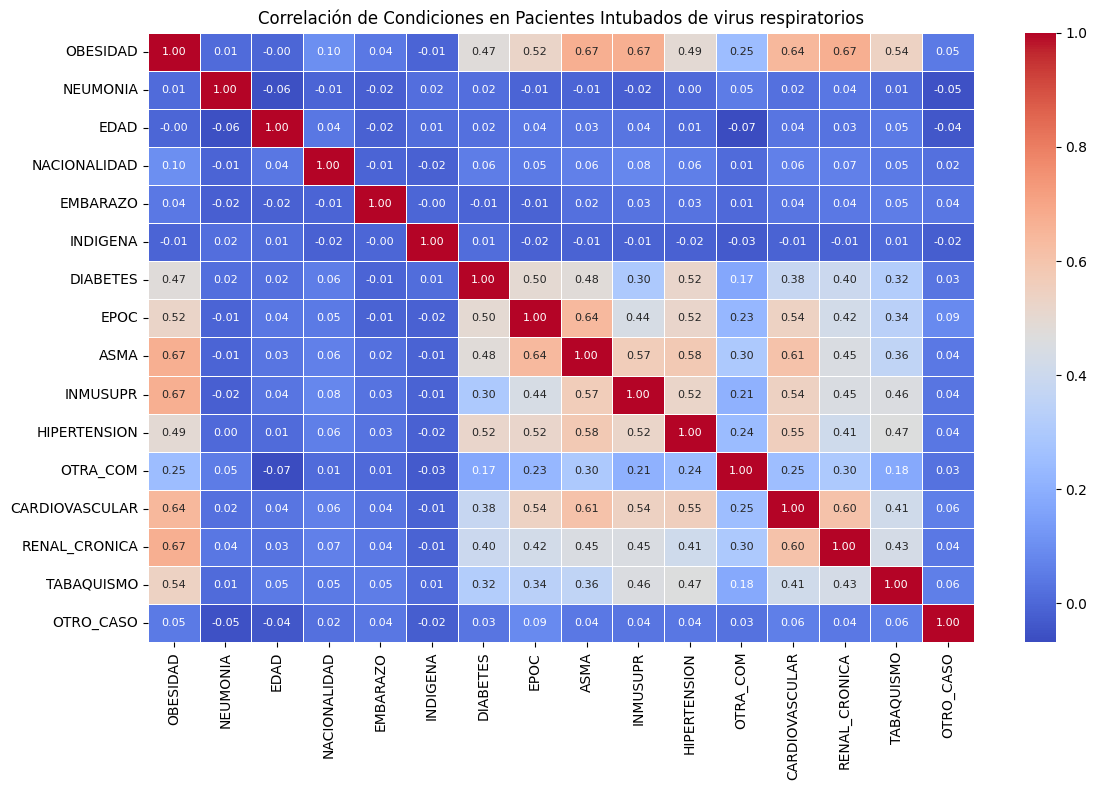

In [ ]:
columns_to_replace = [
    'NEUMONIA', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR',
    'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA'
]

for col in columns_to_replace:
    df_covid[col] = df_covid[col].replace({'SI': 1}).astype('Int64')  # Usar 'Int64' para manejar valores nulos


# Filtrar pacientes intubados
df_covid19_intubado = df_covid[df_covid['INTUBADO'] == 1]  # Usamos 1 para "Sí"

# Seleccionar las columnas de interés
df_covid19_resultado = df_covid19_intubado[['OBESIDAD', 'NEUMONIA', 'EDAD',
                                                'NACIONALIDAD', 'EMBARAZO', 'INDIGENA', 'DIABETES',
                                                'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
                                                'CARDIOVASCULAR', 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO']]

# Reemplazar valores específicos por NaN
df_covid19V2_resultado = df_covid19_resultado.replace(['Se ignora', 'No Aplica', 'No especificado'], np.nan)

# Eliminar filas con valores NaN
df_covid19V2_resultado_clean = df_covid19_resultado.dropna()

# Crear el heatmap de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(df_covid19V2_resultado_clean.corr(), annot=True,annot_kws={"size": 8}, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title('Correlación de Condiciones en Pacientes Intubados de virus respiratorios')
save_fig('Correlacion_Condiciones_Pacientes_Intubados_COVID19' , fig_extension="pdf")
plt.show()

### Pruebas de hipotesis

In [ ]:
#Primera prueba de hipotesis

## Selección de Caracteristicas

En este apartado realizaremos:

- Aplicar algún método de filtro a tus datos mediante el uso de SelectKBest
- Aplicar los modelos de selección de características cuidando los supuestos de cada modelo
- Busca una o varias métricas para seleccionar características en literatura relacionada del problema.
- Con base en tu investigación, determina las características más relevantes de tu conjunto de datos.

### Separacion de las columnas.

Nos interesara saber si un paciente da positivo a SARS-CoV-2, por ese motivo, elegimos la variable dependiente



```
y = df_covid[["CLASIFICACION_FINAL_COVID"]]
```

Mientras que las demas variables del conjunto de datos seran nuestras variables independientes

```
x = df_covid[[ 'EDAD', 'NEUMONIA',
              'EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
              'INMUSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO']]
```


Encontramos si hay linealidad entre las columnas independientes y dependientes

In [ ]:
df_covid_dropna = df_covid.dropna()
y = df_covid_dropna[["CLASIFICACION_FINAL_COVID"]]
x = df_covid_dropna[[ 'EDAD', 'NEUMONIA','EMBARAZO', 'DIABETES', 'EPOC', 'ASMA',
                      'INMUSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO']]

In [ ]:
valor_f = f_regression(x,y)
valor_f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(array([11.10287988,  0.51983557,  0.43649581,  0.08116167,  0.45321591,
         0.38603084,  2.47225663,  0.04986435,  0.43395046,  1.37673979,
         0.34444056,  0.05645221]),
 array([0.00086839, 0.47094659, 0.50885003, 0.77574145, 0.5008438 ,
        0.53442238, 0.1159367 , 0.82330889, 0.51008814, 0.24071489,
        0.55730452, 0.81220392]))

In [ ]:
#Se crea un arreglo para identificar cuales variables pasan la prueba de linealidad
pasan_prueba = []
no_pasan_prueba=[]
alpha = 0.05

for i in range (len(valor_f[0])):
  if valor_f[0][i] < alpha:
    pasan_prueba.append(x.columns[i])
  else:
    no_pasan_prueba.append(x.columns[i])

In [ ]:
pasan_prueba

['HIPERTENSION']

In [ ]:
df_resultados = pd.DataFrame(valor_f[0], index = x.columns, columns= ['valor_f']).sort_values('valor_f', ascending = True)
df_resultados

,valor_f
HIPERTENSION,0.049864
TABAQUISMO,0.056452
DIABETES,0.081162
RENAL_CRONICA,0.344441
ASMA,0.386031
CARDIOVASCULAR,0.433950
EMBARAZO,0.436496
EPOC,0.453216
NEUMONIA,0.519836
OBESIDAD,1.376740


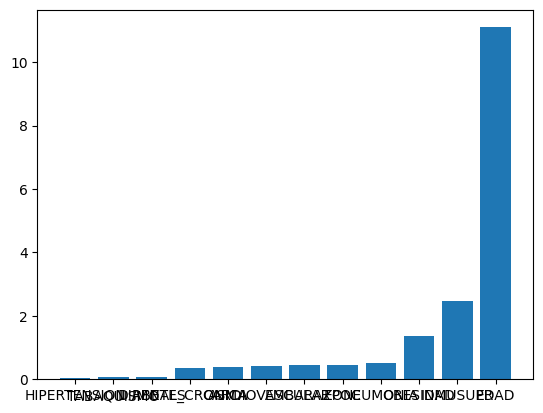

In [ ]:
plt.figure()
plt.bar(df_resultados.index, df_resultados.valor_f)
plt.show()

### Umbral de varianza

Para esto, tenemos que normalizar las variables.

In [ ]:
escalador = MinMaxScaler()
escala = escalador.fit_transform(x)
x_escalada = pd.DataFrame(escala, columns=x.columns)
x_escalada

,EDAD,NEUMONIA,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO
0,0.663551,0.0,0.010309,0.000000,0.010309,0.010309,0.000000,0.010309,0.010309,0.010309,0.010309,0.010309
1,0.457944,0.0,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309
2,0.700935,1.0,0.989691,0.010309,0.000000,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309
3,0.635514,0.0,0.989691,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.000000
4,0.672897,1.0,0.989691,0.000000,0.000000,0.010309,0.010309,0.010309,0.000000,0.010309,0.010309,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
4846,0.887850,0.0,0.989691,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.000000
4847,0.411215,0.0,0.010309,0.010309,0.000000,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309,0.010309
4848,0.719626,1.0,0.989691,0.000000,0.010309,0.010309,0.010309,0.000000,0.010309,0.000000,0.010309,0.010309
4849,0.467290,1.0,0.989691,0.010309,0.010309,0.010309,0.000000,0.010309,0.010309,0.010309,0.010309,0.010309


Una vez obtenida las variables normalizadas, obtenemos las varianzas

In [ ]:
selector = VarianceThreshold()
selector.fit_transform(x_escalada)
selector.variances_

array([0.05320245, 0.22694936, 0.23543728, 0.00407455, 0.00323727,
       0.00282237, 0.00162202, 0.00246203, 0.00283548, 0.00202992,
       0.00283673, 0.00424096])

In [ ]:
df_resultados['varianza'] = selector.variances_
df_resultados

,valor_f,varianza
HIPERTENSION,0.049864,0.053202
TABAQUISMO,0.056452,0.226949
DIABETES,0.081162,0.235437
RENAL_CRONICA,0.344441,0.004075
ASMA,0.386031,0.003237
CARDIOVASCULAR,0.433950,0.002822
EMBARAZO,0.436496,0.001622
EPOC,0.453216,0.002462
NEUMONIA,0.519836,0.002835
OBESIDAD,1.376740,0.002030


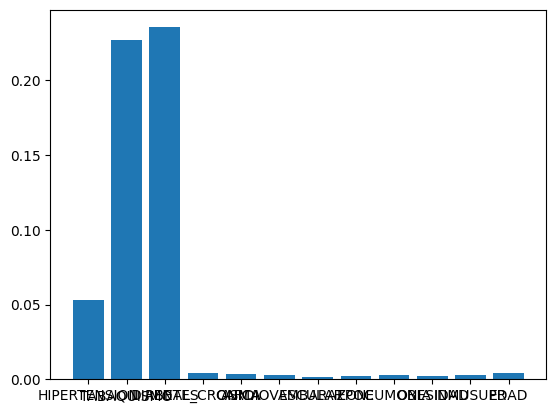

In [ ]:
plt.figure()
plt.bar(df_resultados.index, df_resultados.varianza)
plt.show()

### Información mutua

Nos permite encontrar relacions no lineales entre los datos

In [ ]:
mi = mutual_info_regression(x,y)
mi

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.01912517, 0.        , 0.        , 0.        , 0.        ,
       0.00039551, 0.        , 0.        , 0.04113074, 0.02873287,
       0.00061139, 0.        ])

In [ ]:
df_resultados['mi'] = mi
df_resultados

,valor_f,varianza,mi
HIPERTENSION,0.049864,0.053202,0.019125
TABAQUISMO,0.056452,0.226949,0.000000
DIABETES,0.081162,0.235437,0.000000
RENAL_CRONICA,0.344441,0.004075,0.000000
ASMA,0.386031,0.003237,0.000000
CARDIOVASCULAR,0.433950,0.002822,0.000396
EMBARAZO,0.436496,0.001622,0.000000
EPOC,0.453216,0.002462,0.000000
NEUMONIA,0.519836,0.002835,0.041131
OBESIDAD,1.376740,0.002030,0.028733


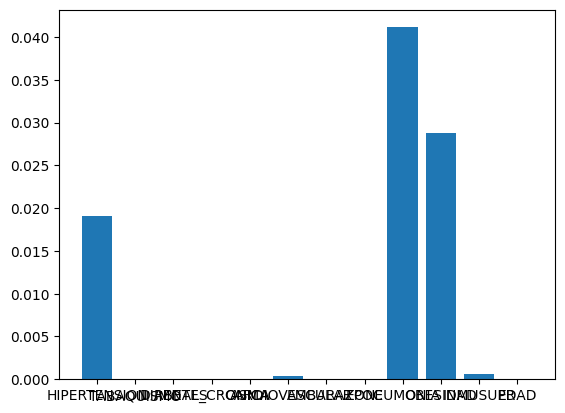

In [ ]:
plt.figure()
plt.bar(df_resultados.index, df_resultados.mi)
plt.show()

Resultados de variables dependientes en manera no lineal

### Reresion lineal

In [ ]:
lr = LinearRegression()
lr

LinearRegression()

In [ ]:
efs = EFS(estimator = lr,   #use linear regression as the classifier/estimator
          min_features = 1, #the minimum number of features to consider is 1
          max_features = 5, # the maximum number of features to consider is 4
          scoring = 'neg_mean_absolute_error', #The metric to use to evluate the classifier is accuracy
          cv = 5)

In [ ]:
efs = efs.fit(x,y)

Features: 1585/1585

In [ ]:
efs.best_score_

np.float64(-0.6760504234527536)

In [ ]:
#la mejor combinacion de la tabla es
efs.best_feature_names_


('EDAD', 'EMBARAZO', 'INMUSUPR', 'TABAQUISMO')

In [ ]:
df_resultados_efs = pd.DataFrame(efs.get_metric_dict()).T
df_resultados_efs = df_resultados_efs.sort_values('avg_score', ascending = False)
df_resultados_efs

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
368,"(0, 2, 6, 11)","[-0.5555018713013419, -0.5556607663961061, -0....",-0.67605,"(EDAD, EMBARAZO, INMUSUPR, TABAQUISMO)",0.146432,0.113929,0.056964
358,"(0, 2, 5, 6)","[-0.5558050697469563, -0.5558946056025471, -0....",-0.676105,"(EDAD, EMBARAZO, ASMA, INMUSUPR)",0.146084,0.113658,0.056829
367,"(0, 2, 6, 10)","[-0.5560603723987758, -0.5553281148036459, -0....",-0.676108,"(EDAD, EMBARAZO, INMUSUPR, RENAL_CRONICA)",0.146244,0.113783,0.056892
91,"(0, 2, 6)","[-0.5560693136777591, -0.5554688686350996, -0....",-0.676126,"(EDAD, EMBARAZO, INMUSUPR)",0.146219,0.113763,0.056882
986,"(0, 2, 6, 10, 11)","[-0.5558544280708214, -0.5556609685817128, -0....",-0.67613,"(EDAD, EMBARAZO, INMUSUPR, RENAL_CRONICA, TABA...",0.146324,0.113845,0.056922
...,...,...,...,...,...,...,...
1254,"(1, 3, 7, 8, 10)","[-0.5571573329084049, -0.5644088719577606, -0....",-0.679344,"(NEUMONIA, DIABETES, HIPERTENSION, CARDIOVASCU...",0.144244,0.112226,0.056113
1233,"(1, 3, 5, 7, 8)","[-0.5567975939823856, -0.5632820445354519, -0....",-0.679362,"(NEUMONIA, DIABETES, ASMA, HIPERTENSION, CARDI...",0.145064,0.112865,0.056432
1299,"(1, 5, 6, 7, 9)","[-0.5579197599968361, -0.5634595201619851, -0....",-0.679371,"(NEUMONIA, ASMA, INMUSUPR, HIPERTENSION, OBESI...",0.144627,0.112524,0.056262
1244,"(1, 3, 6, 7, 9)","[-0.5581813219504462, -0.5635927332607847, -0....",-0.679388,"(NEUMONIA, DIABETES, INMUSUPR, HIPERTENSION, O...",0.144361,0.112318,0.056159


[]

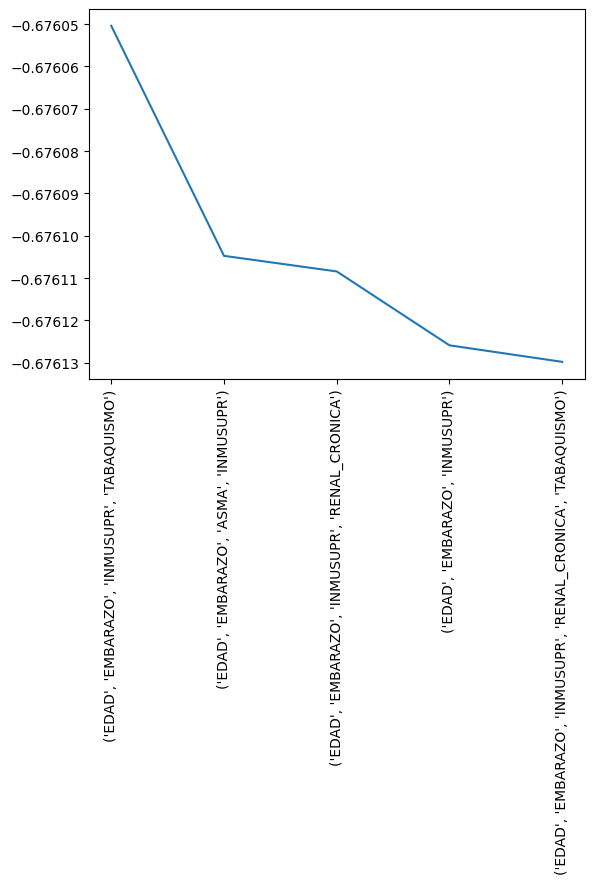

In [ ]:
plt.figure()

plt.plot(
    df_resultados_efs.iloc[:5].feature_names.astype(str),
    df_resultados_efs.iloc[:5].avg_score

)
#plt.gca().invert_yaxis()
plt.xticks(rotation = 90)
plt.plot()

queremos el mas cercano al cero para considerar la mejor

### Sequencial Feature Selector

In [ ]:
sfs = SFS(
    estimator = lr,
    k_features = (1,5),
    forward = True,
    scoring = 'neg_mean_absolute_error',
    cv=5
)

In [ ]:
sfs = sfs.fit(x,y)

In [ ]:
sfs.k_feature_names_

('EDAD', 'EMBARAZO', 'INMUSUPR', 'TABAQUISMO')

In [ ]:
pd.DataFrame(sfs.subsets_).T.sort_values('avg_score', ascending = False)

,feature_idx,cv_scores,avg_score,feature_names
4,"(0, 2, 6, 11)","[-0.5555018713013419, -0.5556607663961061, -0....",-0.67605,"(EDAD, EMBARAZO, INMUSUPR, TABAQUISMO)"
3,"(0, 2, 6)","[-0.5560693136777591, -0.5554688686350996, -0....",-0.676126,"(EDAD, EMBARAZO, INMUSUPR)"
5,"(0, 2, 6, 10, 11)","[-0.5558544280708214, -0.5556609685817128, -0....",-0.67613,"(EDAD, EMBARAZO, INMUSUPR, RENAL_CRONICA, TABA..."
2,"(0, 6)","[-0.5566511172802537, -0.5556943124533584, -0....",-0.676234,"(EDAD, INMUSUPR)"
1,"(0,)","[-0.5566315193441884, -0.5565174665890306, -0....",-0.676439,"(EDAD,)"


Las variables que mas contribuyen son la edad y el embarazo

In [ ]:
df_covid

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,RESULTADO_PCR,RESULTADO_PCR_COINFECCION,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL_COVID,CLASIFICACION_FINAL_FLU,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2025-10-28,167f1a,1,12,1,2,1,1,3,1,...,997,997,2,97,6,6,99,México,97,97
1,2025-10-28,gbbb80b,1,4,20,2,20,20,413,1,...,997,997,2,97,6,6,99,México,97,97
2,2025-10-28,gd8311d,1,8,9,1,9,9,12,1,...,997,997,2,97,6,6,99,México,97,97
3,2025-10-28,g98e198,1,15,21,1,21,21,114,2,...,3,998,2,97,7,3,99,México,97,2
4,2025-10-28,g5075fe,1,6,9,1,29,9,5,2,...,5,5,2,97,7,7,99,México,97,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129172,2025-10-28,g7b5944,1,12,4,2,28,4,2,2,...,999,999,2,97,6,6,99,México,97,2
129173,2025-10-28,g4a3482,1,15,17,1,17,17,7,1,...,997,997,2,97,6,6,99,México,97,97
129174,2025-10-28,gdeb4f5,1,12,4,2,4,4,2,2,...,999,999,2,97,6,6,99,México,97,1
129175,2025-10-28,g5e54db,1,6,29,2,29,29,18,2,...,999,999,2,97,6,6,99,México,97,1


In [ ]:
df_covid.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_PCR',
       'RESULTADO_PCR_COINFECCION', 'TOMA_MUESTRA_ANTIGENO',
       'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL_COVID',
       'CLASIFICACION_FINAL_FLU', 'MIGRANTE', 'PAIS_NACIONALIDAD',
       'PAIS_ORIGEN', 'UCI'],
      dtype='object')

## Agrupación

Aqui poner descripcion de DBSCAN con Gower.

### Filtrado

In [ ]:
#filtrado de las variables categoricas
# Lista de columnas seleccionadas
columnas_gow = [
 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES',
 'TIPO_PACIENTE', 'INTUBADO', 'NEUMONIA', 'EDAD', 'NACIONALIDAD',
 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA', 'DIABETES', 'EPOC', 'ASMA',
 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
 'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'TOMA_MUESTRA_LAB',
 'RESULTADO_PCR', 'RESULTADO_PCR_COINFECCION', 'TOMA_MUESTRA_ANTIGENO',
 'RESULTADO_ANTIGENO', 'UCI'
]

# Filtramos el dataset original
df_gow = df_covid[columnas_gow + ['CLASIFICACION_FINAL_COVID']].sample(n=20000, random_state=42).copy()

#Seleccionamos una muestra del total de filas, debido a que  Gower aumenta al cuadrado de el numero de filas
#por ende no podre poner todas, gano la batalla pero no al guerra

### DBSCAN + Gower

In [ ]:
# Convertimos todas las columnas numéricas a float
df_gow = df_gow.astype(float)

# Calculamos la matriz de distancias de Gower
dist_gower = gower.gower_matrix(df_gow)

Determinamos eps y min_sample optimos para DBSCAN, de acuerdo a las buenas practicas de https://stataiml.com/posts/how_to_set_dbscan_paramter/

 BÚSQUEDA DE PARÁMETROS ÓPTIMOS PARA DBSCAN

 INFORMACIÓN DEL DATASET:
   • Número de características (dimensiones): 31
   • Número de muestras: 20,000

 CANDIDATOS PARA MIN_SAMPLES:
------------------------------------------------------------
   • Regla 1 (= dimensionalidad): 31
   • Regla 2 (2 * dimensionalidad): 62
   • Regla 3 (conservador para ruido): 77
   • Regla 4 (muy conservador): 93


 CALCULANDO DISTANCIAS K-NN PARA CADA CANDIDATO...

Procesando k = 31 (Regla 1 (= dimensionalidad))...
Procesando k = 62 (Regla 2 (2 * dimensionalidad))...
Procesando k = 77 (Regla 3 (conservador para ruido))...
Procesando k = 93 (Regla 4 (muy conservador))...
Imagen guardada como  dbscan_knn_distance_optimal_eps en la carpeta Galeria


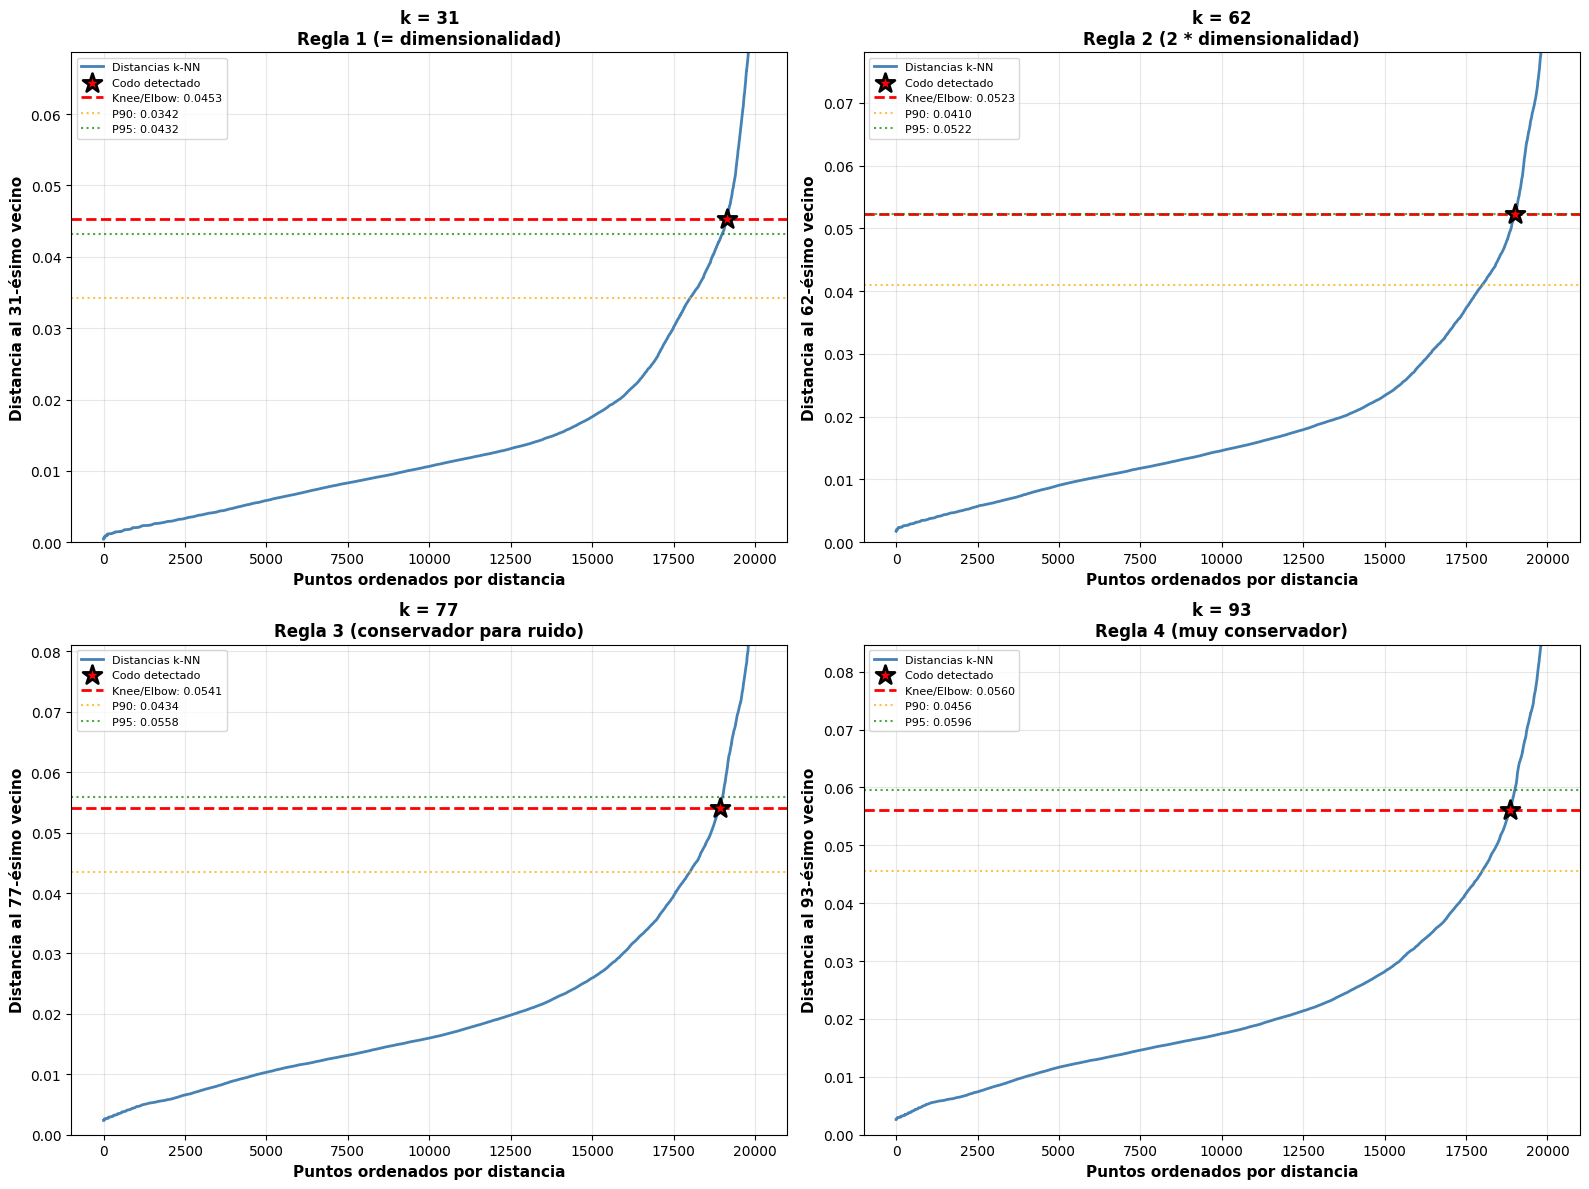


 RESUMEN DE VALORES EPS ÓPTIMOS POR MIN_SAMPLES
Min_Samples     Eps (Knee)      Eps (P90)       Eps (P95)       Regla
--------------------------------------------------------------------------------
31              0.0453          0.0342          0.0432          Regla 1 (= dimensionalidad)
62              0.0523          0.0410          0.0522          Regla 2 (2 * dimensionalidad)
77              0.0541          0.0434          0.0558          Regla 3 (conservador para ruid
93              0.0560          0.0456          0.0596          Regla 4 (muy conservador)


 EVALUANDO CALIDAD DE CLUSTERING CON LAS COMBINACIONES ÓPTIMAS...

 TOP 10 MEJORES CONFIGURACIONES:
 min_samples      eps eps_tipo  n_clusters  pct_noise  silhouette
          93 0.059558      P95           2      1.110    0.513178
          77 0.055842      P95           2      1.405    0.513888
          31 0.045273     Knee           2      1.560    0.514075
          62 0.052344     Knee           2      1.605    0.5147

In [ ]:
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print(" BÚSQUEDA DE PARÁMETROS ÓPTIMOS PARA DBSCAN")
print("="*80)

# ============================================
# 1. DETERMINAR MIN_SAMPLES BASADO EN DIMENSIONALIDAD
# ============================================
n_features = len(columnas_gow)  # 32 columnas
n_samples = len(df_gow)  # 20,000 filas

print(f"\n INFORMACIÓN DEL DATASET:")
print(f"   • Número de características (dimensiones): {n_features}")
print(f"   • Número de muestras: {n_samples:,}")

# Reglas para MinPts según la literatura:
min_pts_candidates = {
    'Regla 1 (= dimensionalidad)': n_features,
    'Regla 2 (2 * dimensionalidad)': 2 * n_features,
    'Regla 3 (conservador para ruido)': int(2.5 * n_features),
    'Regla 4 (muy conservador)': int(3 * n_features)
}

print(f"\n CANDIDATOS PARA MIN_SAMPLES:")
print("-" * 60)
for regla, valor in min_pts_candidates.items():
    print(f"   • {regla}: {valor}")

# ============================================
# 2. FUNCIÓN PARA DETECTAR EL CODO (KNEE/ELBOW)
# ============================================
def detectar_codo(x, y):
    """
    Detecta el punto del codo usando el método de la máxima curvatura.
    """
    # Normalizamos los datos
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))

    # Calculamos la línea que conecta el primer y último punto
    p1 = np.array([x_norm[0], y_norm[0]])
    p2 = np.array([x_norm[-1], y_norm[-1]])

    # Calculamos la distancia perpendicular de cada punto a esta línea
    distancias = []
    for i in range(len(x_norm)):
        p = np.array([x_norm[i], y_norm[i]])
        # Distancia del punto a la línea
        d = np.abs(np.cross(p2-p1, p1-p)) / np.linalg.norm(p2-p1)
        distancias.append(d)

    # El codo es donde la distancia es máxima
    knee_idx = np.argmax(distancias)

    return knee_idx, y[knee_idx]

# ============================================
# 3. MÉTODO K-NN PARA ENCONTRAR EPS ÓPTIMO
# ============================================
print(f"\n\n CALCULANDO DISTANCIAS K-NN PARA CADA CANDIDATO...\n")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

resultados_eps = {}
idx = 0

for nombre_regla, k_value in min_pts_candidates.items():
    print(f"Procesando k = {k_value} ({nombre_regla})...")

    # Calculamos distancias al k-ésimo vecino más cercano
    k_distances = []

    for i in range(len(dist_gower)):
        # Obtenemos las distancias ordenadas (excluyendo la distancia a sí mismo)
        distances = np.sort(dist_gower[i])[1:k_value+1]
        # Guardamos la distancia al k-ésimo vecino
        k_distances.append(distances[-1])

    # Ordenamos las distancias
    k_distances_sorted = np.sort(k_distances)

    # Detectamos el codo automáticamente
    x_vals = np.arange(len(k_distances_sorted))
    knee_idx, eps_optimo = detectar_codo(x_vals, k_distances_sorted)

    # También calculamos percentiles como referencia
    eps_p90 = np.percentile(k_distances_sorted, 90)
    eps_p95 = np.percentile(k_distances_sorted, 95)
    eps_p98 = np.percentile(k_distances_sorted, 98)

    # Guardamos resultados
    resultados_eps[k_value] = {
        'nombre': nombre_regla,
        'eps_knee': eps_optimo,
        'eps_p90': eps_p90,
        'eps_p95': eps_p95,
        'eps_p98': eps_p98,
        'knee_idx': knee_idx,
        'k_distances': k_distances_sorted
    }

    # Graficamos
    axes[idx].plot(k_distances_sorted, linewidth=2, color='steelblue', label='Distancias k-NN')

    # Marcamos el codo detectado
    axes[idx].scatter([knee_idx], [eps_optimo], color='red', s=200, zorder=5,
                      marker='*', edgecolors='black', linewidths=2,
                      label=f'Codo detectado')
    axes[idx].axhline(y=eps_optimo, color='red', linestyle='--', linewidth=2,
                      label=f'Knee/Elbow: {eps_optimo:.4f}')
    axes[idx].axhline(y=eps_p90, color='orange', linestyle=':', alpha=0.7,
                      label=f'P90: {eps_p90:.4f}')
    axes[idx].axhline(y=eps_p95, color='green', linestyle=':', alpha=0.7,
                      label=f'P95: {eps_p95:.4f}')

    axes[idx].set_xlabel('Puntos ordenados por distancia', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel(f'Distancia al {k_value}-ésimo vecino', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'k = {k_value}\n{nombre_regla}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].legend(loc='upper left', fontsize=8)

    # Zoom en la región del codo
    if eps_optimo < np.max(k_distances_sorted) * 0.5:
        axes[idx].set_ylim([0, np.percentile(k_distances_sorted, 99)])

    idx += 1

# Guardamos la figura con la función personalizada
save_fig('dbscan_knn_distance_optimal_eps', tight_layout=True, fig_extension="pdf", resolution=300)
plt.show()

# ============================================
# 4. RESUMEN DE VALORES ÓPTIMOS
# ============================================
print("\n" + "="*80)
print(" RESUMEN DE VALORES EPS ÓPTIMOS POR MIN_SAMPLES")
print("="*80)
print(f"{'Min_Samples':<15} {'Eps (Knee)':<15} {'Eps (P90)':<15} {'Eps (P95)':<15} {'Regla'}")
print("-"*80)

for k_value, datos in resultados_eps.items():
    print(f"{k_value:<15} {datos['eps_knee']:<15.4f} {datos['eps_p90']:<15.4f} "
          f"{datos['eps_p95']:<15.4f} {datos['nombre'][:30]}")

# ============================================
# 5. EVALUACIÓN DE LAS MEJORES COMBINACIONES
# ============================================
print("\n\n EVALUANDO CALIDAD DE CLUSTERING CON LAS COMBINACIONES ÓPTIMAS...\n")

evaluaciones = []

for k_value, datos in resultados_eps.items():
    # Probamos con el eps del knee y los percentiles
    for eps_tipo, eps_valor in [('Knee', datos['eps_knee']),
                                 ('P90', datos['eps_p90']),
                                 ('P95', datos['eps_p95'])]:

        # Aplicamos DBSCAN
        db_temp = DBSCAN(metric="precomputed", eps=eps_valor, min_samples=k_value)
        labels = db_temp.fit_predict(dist_gower)

        # Métricas
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        pct_noise = (n_noise / len(labels)) * 100

        # Calculamos silhouette si es posible
        silhouette = None
        if n_clusters >= 2 and n_noise < len(labels):
            mask = labels != -1
            if sum(mask) > 10:
                try:
                    silhouette = silhouette_score(dist_gower[mask][:, mask],
                                                   labels[mask],
                                                   metric='precomputed')
                except:
                    silhouette = None

        evaluaciones.append({
            'min_samples': k_value,
            'eps': eps_valor,
            'eps_tipo': eps_tipo,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'pct_noise': pct_noise,
            'silhouette': silhouette,
            'regla': datos['nombre']
        })

# Convertimos a DataFrame y mostramos resultados
import pandas as pd
df_eval = pd.DataFrame(evaluaciones)

# Filtramos solo resultados válidos (con clusters y no demasiado ruido)
df_eval_validos = df_eval[(df_eval['n_clusters'] >= 2) & (df_eval['pct_noise'] < 50)].copy()

if len(df_eval_validos) > 0:
    # Ordenamos por menor ruido y luego por mayor silhouette
    df_eval_validos = df_eval_validos.sort_values(
        by=['pct_noise', 'silhouette'],
        ascending=[True, False]
    )

    print(" TOP 10 MEJORES CONFIGURACIONES:")
    print("="*100)
    print(df_eval_validos[['min_samples', 'eps', 'eps_tipo', 'n_clusters', 'pct_noise', 'silhouette']].head(10).to_string(index=False))

    # Mejor configuración
    mejor = df_eval_validos.iloc[0]

    print("\n" + "="*80)
    print(" CONFIGURACIÓN ÓPTIMA RECOMENDADA")
    print("="*80)
    print(f"\n PARÁMETROS:")
    print(f"   min_samples = {int(mejor['min_samples'])}")
    print(f"   eps = {mejor['eps']:.4f} (método: {mejor['eps_tipo']})")
    print(f"\n RESULTADOS ESPERADOS:")
    print(f"   • Número de clusters: {int(mejor['n_clusters'])}")
    print(f"   • Puntos de ruido: {int(mejor['n_noise'])} ({mejor['pct_noise']:.2f}%)")
    if mejor['silhouette'] is not None:
        print(f"   • Silhouette Score: {mejor['silhouette']:.4f}")
    print(f"   • Basado en: {mejor['regla']}")
print("\n" + "="*80)

In [ ]:
# Ajustamos el modelo DBSCAN usando la matriz de Gower
db = DBSCAN(metric="precomputed", eps=0.0605, min_samples=93) #eps = radio de la vecindad, min_samples indica cuantos punto tiene que tener como minimo un clouster
#esto despues se mejorara para encontrar el mejor eps
db.fit(dist_gower)

# Guardamos los clusters en un nuevo DataFrame
df_gow['cluster'] = db.labels_

In [ ]:
# Verificamos resultados
df_gow['cluster'].unique()

array([ 0,  1, -1])

In [ ]:
print(f"Clusters encontrados: {len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)}")
print(f"Puntos de ruido: {list(db.labels_).count(-1)}")

Clusters encontrados: 2
Puntos de ruido: 210


Apreciamos que el algoritmo detecta 220 puntos de ruido, en proporcion respecto a mis 20,000 datos muestrales equivale al 1.1% lo cual esta en el rango aceptable. Visualizaremos ahora los clousters junto con el ruido

Imagen guardada como  clusters_dbscan_gower en la carpeta Galeria


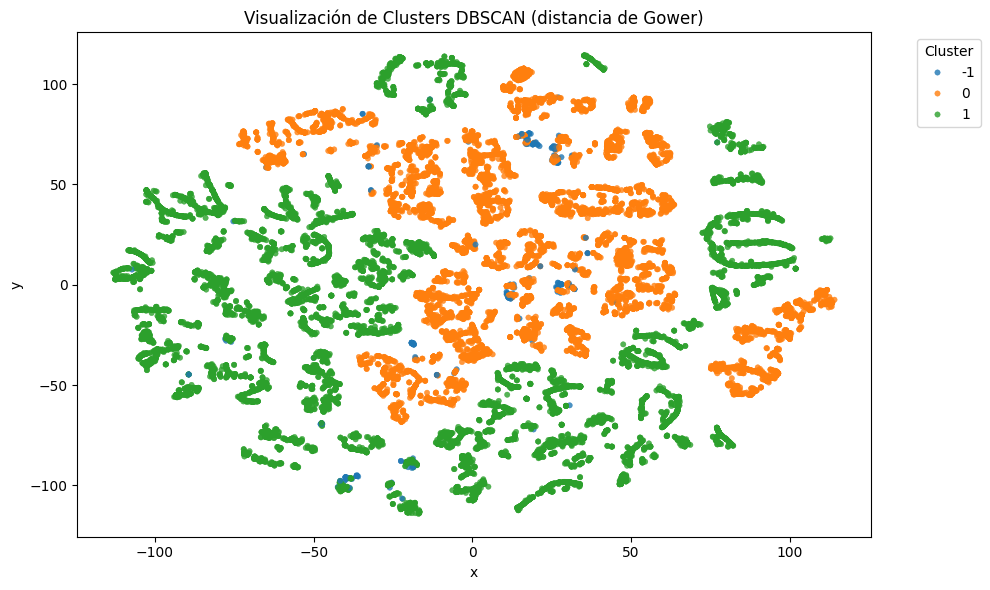

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# --- OPCIÓN 1: PCA para exploracion ---
#pca = PCA(n_components=2, random_state=42)
#coords_pca = pca.fit_transform(dist_gower)

# --- OPCIÓN 2: t-SNE para grafico final ---
tsne = TSNE(n_components=2, metric="precomputed", random_state=42, perplexity=30, init="random")
coords_tsne = tsne.fit_transform(dist_gower)

# Elegimos una opción para graficar:
coords = coords_tsne #coords_pca  # o coords_tsne si usas t-SNE

# Agregamos coordenadas al DataFrame
df_gow['x'] = coords[:, 0]
df_gow['y'] = coords[:, 1]

# --- Graficamos ---
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_gow,
    x='x', y='y',
    hue='cluster',
    palette='tab10',  # paleta de colores
    s=15,
    alpha=0.8,
    edgecolor=None
)
plt.title('Visualización de Clusters DBSCAN (distancia de Gower)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
save_fig("clusters_dbscan_gower", fig_extension="pdf", resolution=300)
plt.show()


# Aprendizaje supervisado.

## Redes Neuronales

### Teoria

Aqui poner teoria

### Preprosesamiento

In [ ]:
# El problema que planteamos es la prediccion de dar positivo a covid 19. Para eso utilizaremos variables
#que sean antes de ingresar al hispital, por lo que las variables seran
col = [
    'SEXO', 'EDAD', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'NACIONALIDAD',
    'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
    'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO' , 'NEUMONIA'
    , 'CLASIFICACION_FINAL_COVID' #variable target
]

# Asignarlas a X
X = df_covid[col].copy()


In [ ]:
#Debido a que no contiene informacion algunas variables, como los casos cuando hay 99, 98, 97
#Vamos a dejarlos como nan para que la red neuronal no asigne un valor a estas categorias.
vars_con_codigos = [
    'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
    'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO' , 'NEUMONIA'
]

# Reemplazar 97,98,99 por NaN en esas columnas
X[vars_con_codigos] = X[vars_con_codigos].replace({97: np.nan, 98: np.nan, 99: np.nan})


In [ ]:
#ahora pero para la variable target
# Crear variable binaria target
X['COVID_POSITIVO'] = X['CLASIFICACION_FINAL_COVID'].map({
    1: 1,
    2: 1,
    3: 1,
    7: 0
})

# Eliminar registros no confirmados o inválidos
#En esta parte s eeliminan los registros que contenian como sospechosos, esto es una muy buena señal
#por que con estos sospechosos puedo darselos a la red neuronal para que me diga si son positivos o negativos
X = X.dropna(subset=['COVID_POSITIVO'])

# Convertir a entero
X['COVID_POSITIVO'] = X['COVID_POSITIVO'].astype(int)

print(X['COVID_POSITIVO'].value_counts())


COVID_POSITIVO
0    72581
1     6956
Name: count, dtype: int64


In [ ]:
#Lo mismo pero para la variable nacionalidad
X['NACIONALIDAD'] = X['NACIONALIDAD'].replace({99: np.nan})

In [ ]:
#Lo mismo para la variable ENTIDAD_rES, MUNICIPAL_RES
X['ENTIDAD_RES'] = X['ENTIDAD_RES'].replace({98: np.nan, 99: np.nan})
X['MUNICIPIO_RES'] = X['MUNICIPIO_RES'].replace({997: np.nan, 998: np.nan, 999: np.nan})

In [ ]:
X.isna().sum()

,0
SEXO,0
EDAD,0
ENTIDAD_RES,0
MUNICIPIO_RES,1
NACIONALIDAD,0
DIABETES,105
EPOC,122
ASMA,110
INMUSUPR,68
HIPERTENSION,71


In [ ]:
#Pasamos ahora a limpiar las variables para el modelo
X['DIABETES'] = X['DIABETES'].replace({1:1, 2:0})
X['EPOC'] = X['EPOC'].replace({1:1, 2:0})
X['ASMA'] = X['ASMA'].replace({1:1, 2:0})
X['INMUSUPR'] = X['INMUSUPR'].replace({1:1, 2:0})
X['HIPERTENSION'] = X['HIPERTENSION'].replace({1:1, 2:0})
X['OTRA_COM'] = X['OTRA_COM'].replace({1:1, 2:0})
X['CARDIOVASCULAR'] = X['CARDIOVASCULAR'].replace({1:1, 2:0})
X['RENAL_CRONICA'] = X['RENAL_CRONICA'].replace({1:1, 2:0})
X['TABAQUISMO'] = X['TABAQUISMO'].replace({1:1, 2:0})
X['NEUMONIA'] = X['NEUMONIA'].replace({1:1, 2:0})
#X['MIGRANTE'] = X['MIGRANTE'].replace({1:1, 2:0})
X['NACIONALIDAD'] = X['NACIONALIDAD'].replace({1:1, 2:0})

In [ ]:
X = X.drop(columns=['CLASIFICACION_FINAL_COVID']) #eliminamos la variable por que ya la tenemos en covid_positivo

In [ ]:
# La idea de imputar es que cambiemos por sus valores correspondientes para cada tipo de variable
#Variables numéricas → imputar con la media o mediana.
# Variables categóricas → imputar con la moda (valor más frecuente).
vars_categoricas = ['SEXO', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'NACIONALIDAD', 'NEUMONIA']
vars_numericas = [
    'EDAD', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
    'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO'
]

# Imputadores
imputer_cat = SimpleImputer(strategy='most_frequent')
imputer_num = SimpleImputer(strategy='median')

# Aplicar imputación
X[vars_categoricas] = imputer_cat.fit_transform(X[vars_categoricas])
X[vars_numericas] = imputer_num.fit_transform(X[vars_numericas])

In [ ]:
# Variables categóricas simples (One-Hot)
vars_onehot = ['SEXO', 'NACIONALIDAD']

# Variables con muchas categorías (Target Encoding)
vars_target = ['ENTIDAD_RES', 'MUNICIPIO_RES']

# Variable objetivo
target = "COVID_POSITIVO"

# Target Encoding
target_mappings = {}

for col in vars_target:
    mapping = X.groupby(col)[target].mean()
    target_mappings[col] = mapping
    X[col] = X[col].map(mapping)

# Guardar los mapeos para usarlos después
joblib.dump(target_mappings, 'target_mappings_covid.pkl')

# One-Hot Encoding para las variables simples
X = pd.get_dummies(X, columns=vars_onehot, drop_first=True)

print("Codificación completada y mapeos guardados en target_mappings_covid.pkl")

Codificación completada y mapeos guardados en target_mappings_covid.pkl


In [ ]:
# Vamos a escalar las variables que no sea numericas para el modelo entrene bien
from sklearn.preprocessing import MinMaxScaler

# Ejemplo de variables numéricas continuas o target-encoded
vars_numericas = ['EDAD', 'ENTIDAD_RES', 'MUNICIPIO_RES']

# Variables binarias (0/1) que NO se escalan
vars_binarias = [col for col in X.columns if col not in vars_numericas]

scaler = MinMaxScaler()

# Ajustar y transformar solo las columnas numéricas
X_scaled = X.copy()
X_scaled[vars_numericas] = scaler.fit_transform(X[vars_numericas])

# Guardar el scaler para usarlo en nuevos datos
import joblib
joblib.dump(scaler, 'Maapeos completada y mapeos guardados en scaler_covid.pkl')

['Maapeos completada y mapeos guardados en scaler_covid.pkl']

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([72581,  6956]))

### Modelo

In [ ]:
from sklearn.model_selection import train_test_split

# Separamos la variable target
y = X_scaled["COVID_POSITIVO"]
X_2 = X_scaled.drop(columns=["COVID_POSITIVO"])

# Dividimos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_2, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
# Convertimos a tensores
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train.values, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

In [ ]:
# Definimos el modelo binario
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_tf.shape[1],),
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),

    Dense(128, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),

    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # binaria
    metrics=['accuracy']
)

entrenando el modelo

In [ ]:
#
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

# Calcular los pesos de clase
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_tf),
    y=y_train_tf.numpy()
)

class_weights_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights_dict)

# Entrenar el modelo con esos pesos
history = model.fit(
    X_train_tf, y_train_tf,
    validation_data=(X_test_tf, y_test_tf),
    epochs=40,
    batch_size=64,
    class_weight=class_weights_dict,
    verbose=1
)

Pesos de clase: {0: np.float64(0.5479212593000826), 1: np.float64(5.716891284815813)}
Epoch 1/40
995/995 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5274 - loss: 0.8025 - val_accuracy: 0.5598 - val_loss: 0.6983
Epoch 2/40
995/995 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.5336 - loss: 0.6938 - val_accuracy: 0.5236 - val_loss: 0.7178
Epoch 3/40
995/995 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5653 - loss: 0.6752 - val_accuracy: 0.5689 - val_loss: 0.6637
Epoch 4/40
995/995 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5607 - loss: 0.6727 - val_accuracy: 0.5956 - val_loss: 0.6597
Epoch 5/40
995/995 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5637 - loss: 0.6771 - val_accuracy: 0.4119 - val_loss: 0.8031
Epoch 6/40
995/995 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5607 - loss: 0.6702 - val_accuracy: 0.5866 - val_loss: 0.6574
Epoch 7/40
995/995 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5834 - loss: 0.6710 - val_accuracy: 0.6047 - val_loss: 0.6430
Epoch 8/40
995/995

In [ ]:
# Evaluar el modelo en el conjunto de prueba
loss, acc = model.evaluate(X_test_tf, y_test_tf, verbose=0)

print(f"Pérdida (loss): {loss:.4f}")
print(f"Exactitud (accuracy): {acc:.4f}")

Pérdida (loss): 0.6402
Exactitud (accuracy): 0.6525


In [ ]:
# Predicciones
y_pred_prob = model.predict(X_test_tf)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Reporte de desempeño
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_tf, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test_tf, y_pred))

498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Matriz de confusión:
[[9546 4971]
 [ 557  834]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.94      0.66      0.78     14517
         1.0       0.14      0.60      0.23      1391

    accuracy                           0.65     15908
   macro avg       0.54      0.63      0.50     15908
weighted avg       0.87      0.65      0.73     15908



Utilizamos SMOTE + undersampling para ver si el modelo mejora, para esto quitamos la asignacion de los pesos para evitar sobreajuste

In [ ]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(sampling_strategy=0.5, random_state=42)  # genera ejemplos minoritarios
under = RandomUnderSampler(sampling_strategy=0.8, random_state=42)  # reduce mayoría

# SMOTE
X_smote, y_smote = smote.fit_resample(X_train, y_train)
# Undersampling
X_train_bal, y_train_bal = under.fit_resample(X_smote, y_smote)

In [ ]:
print("Distribución antes:", Counter(y_train))
print("Distribución después:", Counter(y_train_bal))

Distribución antes: Counter({0: 58064, 1: 5565})
Distribución después: Counter({0: 36290, 1: 29032})


In [ ]:
X_train_tf = tf.convert_to_tensor(X_train_bal, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train_bal.values, dtype=tf.float32)

X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test.values, dtype=tf.float32)

In [ ]:
# Definimos el modelo binario
#añadimos mas capas
# añadiendo Batch en cada capa (estabiliza el entrenamiento, mejora convergencia.)
#Dropout progresivo (0.3 → 0.2): previene sobreajuste reduciendo gradualmente la tasa conforme profundizas.

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tf.shape[1],),
          kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.25),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0005)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilamos el modelo
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Entrenamos SIN class_weight
history = model.fit(
    X_train_tf, y_train_tf,
    validation_data=(X_test_tf, y_test_tf),
    epochs=40,
    batch_size=64,
    verbose=1
)

# Evaluación
loss, acc = model.evaluate(X_test_tf, y_test_tf)
print(f"Exactitud del modelo: {acc:.3f}")

Epoch 1/40
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.5896 - loss: 0.9578 - val_accuracy: 0.6347 - val_loss: 0.8035
Epoch 2/40
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6248 - loss: 0.7994 - val_accuracy: 0.6794 - val_loss: 0.6540
Epoch 3/40
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - accuracy: 0.6312 - loss: 0.7179 - val_accuracy: 0.6543 - val_loss: 0.6287
Epoch 4/40
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.6286 - loss: 0.6830 - val_accuracy: 0.7115 - val_loss: 0.5581
Epoch 5/40
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.6294 - loss: 0.6679 - val_accuracy: 0.6986 - val_loss: 0.5746
Epoch 6/40
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6311 - loss: 0.6630 - val_accuracy: 0.7489 - val_loss: 0.5528
Epoch 7/40
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.6302 - loss: 0.6610 - val_accuracy: 0.5888 - val_loss: 0.6619
Epoch 8/40
1021/1021 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.6299 -

In [ ]:
# Predicciones
y_pred_prob = model.predict(X_test_tf)
y_pred = (y_pred_prob > 0.575).astype(int).flatten()

# Reporte de desempeño
print("\nMatriz de confusión:")
print(confusion_matrix(y_test_tf, y_pred))

print("\nReporte de clasificación:")
print(classification_report(y_test_tf, y_pred))

498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Matriz de confusión:
[[11459  3058]
 [  769   622]]

Reporte de clasificación:
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86     14517
         1.0       0.17      0.45      0.25      1391

    accuracy                           0.76     15908
   macro avg       0.55      0.62      0.55     15908
weighted avg       0.87      0.76      0.80     15908



Ajustamos el umbral optimo

In [ ]:
from sklearn.metrics import precision_recall_curve, f1_score

# Probabilidades predichas
y_pred_prob = model.predict(X_test_tf)

# Calculamos F1 para distintos umbrales
prec, rec, thresholds = precision_recall_curve(y_test_tf, y_pred_prob)
f1_scores = 2 * prec * rec / (prec + rec)

# Buscamos el mejor umbral
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)

print(f"Mejor umbral: {best_threshold:.3f}")
print(f"Mejor F1-score: {best_f1:.3f}")

# Predicciones con el nuevo umbral
y_pred_opt = (y_pred_prob > best_threshold).astype(int)

print("\nMatriz de confusión (umbral óptimo):")
print(confusion_matrix(y_test_tf, y_pred_opt))

print("\nReporte de clasificación (umbral óptimo):")
print(classification_report(y_test_tf, y_pred_opt))

498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mejor umbral: 0.575
Mejor F1-score: 0.242

Matriz de confusión (umbral óptimo):
[[11039  3478]
 [  723   668]]

Reporte de clasificación (umbral óptimo):
              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84     14517
         1.0       0.16      0.48      0.24      1391

    accuracy                           0.74     15908
   macro avg       0.55      0.62      0.54     15908
weighted avg       0.87      0.74      0.79     15908

